# 7. Visual Search - Calling Azure Cognitive Search

<img src="https://github.com/retkowsky/images/blob/master/visualsearchlogo.jpg?raw=true">

# Visual Search with Azure Cognitive Search, Sentence Transformers, Azure Computer Vision and bar code/QR code detection

## Description
The goal of this is **Azure AI asset is to enable search over Text and Images using Azure Cognitive Search**. The technique was inspired by a research article which show how to **convert vectors (embeddings) to text which allows the Cognitive Search service to leverage the inverted index to quickly find the most relevant items**. For this reason, any model that will convert an object to a vector can be leveraged if the number of dimensions in the resulting vector is less than 3,000. It also allows users to leverage existing pretrained or fine-tuned models.<br><br>

This technique has shown to be incredibly effective and easy to implement. We are using **Sentence Transformers, which is an OpenAI clip model wrapper**. We need to embed all our existing catalog of images. Then the objects embedding are converted into a set of fake terms and all the results are stored into an Azure Cognitive Search index for handling all the search requests.
For example, if an embedding looked like [-0,21, .123, ..., .876], this might be converted to a set of fake terms such as: “A1 B3 … FED0”. This is what is sent as the search query to Azure Cognitive Search.<br><br>

We can **enrich the Azure Cognitive Search index by using extracted text from the images using Azure Read API**. We can also detect and extract any information from **bar code and/or QR code** that might be available in the products catalog images. And we can use also **Azure Computer Vision as well to detect the dominant colors of the image, the tags that can describe the image and the caption of each image**. All these information will be ingested into the Azure Cognitive Search index.<br><br>

The goal of this asset is to be able to use the inverted index within Azure Cognitive Search to be able to quickly find vectors stored in the search index that are like a vector provided as part of a search query and/or using any AI extracted information (text, dominant colors, …). Unlike techniques like cosine similarity which are slow to process large numbers of items, this leverages an inverted index which enables much more data to be indexed and searched.<br>

## Process

- We have here a collection of catalog images (466 images).
- For each of these images, we will embed them using Sentence Transformers.  Sentence Transformer can be used to map images and texts to the same vector space. As model, we use the OpenAI CLIP Model which was trained on a large set of images and image alt texts.
- We can retrieve any text from these images using Azure Read API (if any text is available)
- We can retrieve any text information from any bar code or QR code (if any)
- All these information will be ingested into an Azure Cognitive Search index
- Then if you have a field image, you can embed it and extract any text/barcode information and call the Azure Cognitive Search index to retrieve any similar images using vecText similarity and/or using any query text from the extracted text


<img src="https://github.com/retkowsky/images/blob/master/process.png?raw=true">

Field images are available in the field images directory (number of images=53)


## Azure products documentation
- https://azure.microsoft.com/en-us/products/search/ 
- https://azure.microsoft.com/en-us/products/cognitive-services/computer-vision/#overview 
- https://learn.microsoft.com/en-us/azure/cognitive-services/Computer-vision/how-to/call-read-api 
- https://zbar.sourceforge.net/ 
- https://github.com/liamca/vector-search

## Research article
https://www.researchgate.net/publication/305910626_Large_Scale_Indexing_and_Searching_Deep_Convolutional_Neural_Network_Features
    
## Directories
- **images**: We have two directories (catalog images, field images)
- **model**: Directory to save the clusters of the model
- **results**: Directory to save some results
- **test**: Directory that contains some testing images

## Python notebooks

### 0. Settings.ipynb
Notebook that contains the link to the images and the importation process of the python required libraries

### 1. Catalog images exploration.ipynb
This notebook will display some catalog and field images

### 2. OpenAI Clip and VecText Clusters.ipynb
This notebook will explain what sentence transformers is and will generate the clusters
This notebook analyzes a set of existing images to determine a set of "cluster centers" that will be used to determine which "fake words" are generated for a vector
This notebook will take a test set of files (testSamplesToTest) and determine the optimal way to cluster vectors into fake words that will be indexed into Azure Cognitive Search

### 3. VecText generation.ipynb
This notebook will generate the vectext embedding for all the catalog images

### 4. BarCode Information extraction.ipynb
This notebook will detect any barcode or QR code from the catalog images and will extract the information

### 5. Azure CV for OCR, tags, colors and captions.ipynb
This notebook will use Azure Computer Vision or OCR, colors, tags and caption extraction for each of the catalog images.

### 6. Azure Cognitive Search Index Generation.ipynb
This notebook will show how to ingest all the information into an Azure Cognitive Search index.

### 7. Calling Azure Cognitive Search.ipynb
We can now test the index using some images similarity visual search or free text queries using azure Cognitive Search.

## Python files

- **azureCognitiveSearch.py**
This python file contains many functions to manage and use Azure Cognitive Search

- **myfunctions.py**
This python file contains many generic functions used in all the notebooks

- **vec2Text.py**
This python file contains some functions for the sentence transformers model


24-oct-2022 Serge Retkowsky | serge.retkowsky@microsoft.com | https://www.linkedin.com/in/serger/

In [1]:
import configparser
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import requests
import sys
import time

from azure.core.credentials import AzureKeyCredential
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from azure.search.documents import SearchClient
from msrest.authentication import CognitiveServicesCredentials

import azureCognitiveSearch as acs
import myfunctions as my
import vec2Text

%matplotlib inline

In [2]:
my.get_system_info()

System Informations:

{
  "Architecture": "x86_64",
  "Hostname": "standardd13",
  "IP-address": "127.0.0.1",
  "MAC-address": "60:45:bd:90:9b:99",
  "Platform": "Linux",
  "Platform-release": "5.4.0-1077-azure",
  "Platform-version": "#80~18.04.1-Ubuntu SMP Wed Apr 13 02:07:09 UTC 2022",
  "Processor": "x86_64",
  "Python version": "3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]",
  "RAM": "55 Gb"
}


In [3]:
my.check_python()

You are using Python: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
This notebook was made using Python 3.8.5 so this is OK


Storage:

Total: 126.8 GB
- Used: 66.4 GB | 52.38 %
- Free: 60.4 GB | 47.61 %


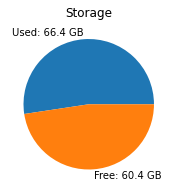

(126774263808, 66400108544, 60357378048)

In [4]:
my.get_storage_infos()

In [5]:
print("Today is:", my.get_today())

Today is: 24-10-2022 15:10:56


## 1. Loading cluster centers file

In [6]:
PKL_FOLDER = "model"
my.list_dir(PKL_FOLDER)

Files in directory: model 

1 	 2022-10-24 14:36:57.169631 29.1 kB 	 cluster_centers_images.pkl


In [7]:
cluster_center_file = 'cluster_centers_images.pkl'

In [8]:
print("Loading pkl file", cluster_center_file)

os.chdir(PKL_FOLDER)

try:
    with open(cluster_center_file, 'rb') as pickle_in:
        clusterCenters = pickle.load(pickle_in)
        print("Done.")
except:
    print("[Error]")

os.chdir("..")

Loading pkl file cluster_centers_images.pkl
Done.


In [9]:
model = vec2Text.openai_clip_model()

Loading OpenAI Clip model: clip-ViT-B-32
Done


## 2. Azure Cognitive Search Index status

In [10]:
config_file = 'azureservices.py'
config = configparser.ConfigParser()
config.read(config_file)
search_key = config.get('AzureCognitiveSearch', 'key')
search_endpoint = config.get('AzureCognitiveSearch', 'endpoint')
search_servicename = config.get('AzureCognitiveSearch', 'servicename')

print("Your credentials (values have been masked for privacy)")
print("Azure Cognitive Search endpoint:",
      search_endpoint[:10] + "************" + search_endpoint[-10:])
print("Azure Cognitive Search key:", search_key[:2] + "************" + search_key[-2:])

Your credentials (values have been masked for privacy)
Azure Cognitive Search endpoint: https://az************indows.net
Azure Cognitive Search key: 0C************C6


In [11]:
print("Azure Cognitive Search service:", 
      search_servicename[:3] + '****')
print("Azure Cognitive Search index is:", acs.index_name)

Azure Cognitive Search service: azu****
Azure Cognitive Search index is: demo-retail


In [12]:
acs.index_status(acs.index_name)

Azure Cognitive Search Index: demo-retail 

{
    "@odata.context": "https://azurecognitivesearchsr.search.windows.net/$metadata#indexes/$entity",
    "@odata.etag": "\"0x8DAB5D1C886D578\"",
    "name": "demo-retail",
    "defaultScoringProfile": null,
    "fields": [
        {
            "name": "Id",
            "type": "Edm.String",
            "searchable": false,
            "filterable": false,
            "retrievable": true,
            "sortable": false,
            "facetable": false,
            "key": true,
            "indexAnalyzer": null,
            "searchAnalyzer": null,
            "analyzer": null,
            "synonymMaps": []
        },
        {
            "name": "Content",
            "type": "Edm.String",
            "searchable": true,
            "filterable": true,
            "retrievable": true,
            "sortable": true,
            "facetable": false,
            "key": false,
            "indexAnalyzer": null,
            "searchAnalyzer": null,
 

## 3. Field images

In [13]:
FIELD_IMAGES = './images/field_images/'
my.number_files(FIELD_IMAGES)

./images/field_images/ = 53

The directory ./images/field_images/ contains 53 files


## 4. Visual Search tests

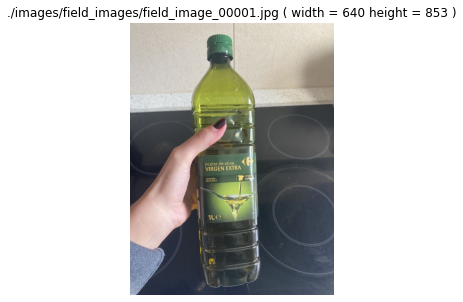

In [14]:
reference_image = FIELD_IMAGES + "field_image_00001.jpg"
my.image_view(reference_image, w=10, h=5, axis=False)

In [15]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=3)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 3 similar images of reference image: ./images/field_images/field_image_00001.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00061.jpg Similarity score = 200.50677 
 2 Similar image: ./images/catalog_images/catalog_image_00455.jpg Similarity score = 197.97575 
 3 Similar image: ./images/catalog_images/catalog_image_00059.jpg Similarity score = 189.89482 

Done in 1.91345 secs


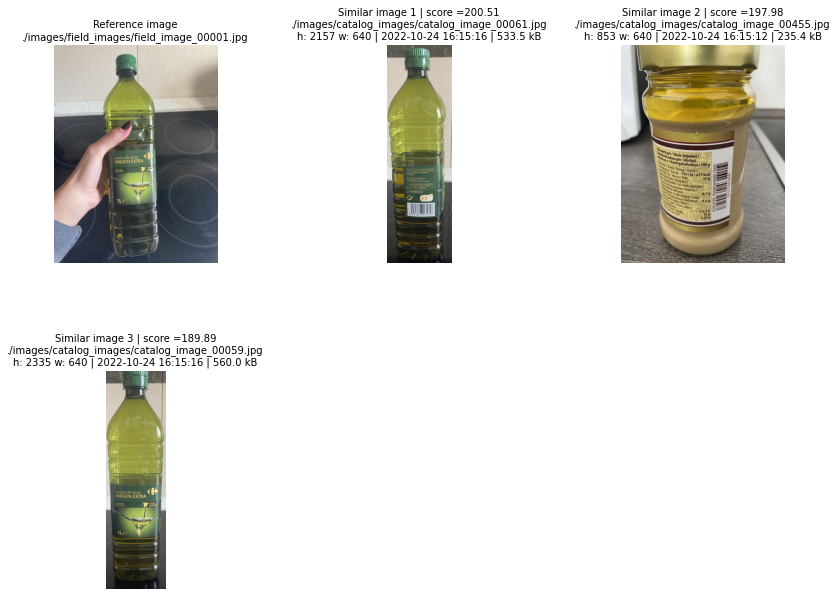

In [16]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

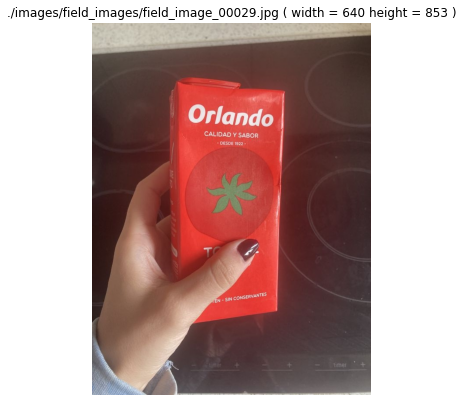

In [17]:
reference_image = FIELD_IMAGES + "field_image_00029.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [18]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=5)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 5 similar images of reference image: ./images/field_images/field_image_00029.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00372.jpg Similarity score = 246.79555 
 2 Similar image: ./images/catalog_images/catalog_image_00055.jpg Similarity score = 236.12154 
 3 Similar image: ./images/catalog_images/catalog_image_00058.jpg Similarity score = 215.01822 
 4 Similar image: ./images/catalog_images/catalog_image_00376.jpg Similarity score = 207.64958 
 5 Similar image: ./images/catalog_images/catalog_image_00374.jpg Similarity score = 183.7117 

Done in 1.24734 secs


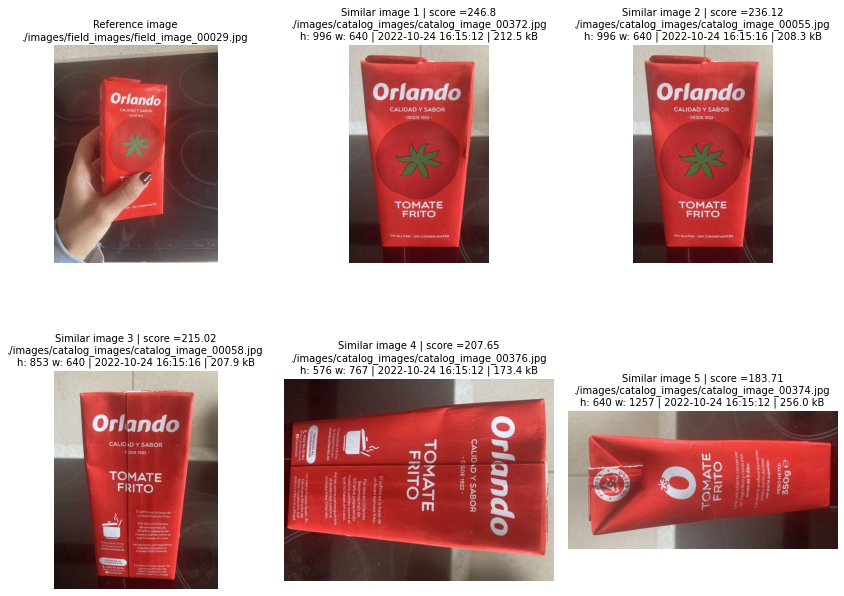

In [19]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

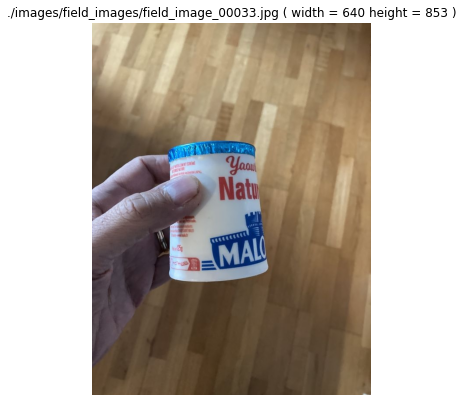

In [20]:
reference_image = FIELD_IMAGES + "field_image_00033.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [21]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=5)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 5 similar images of reference image: ./images/field_images/field_image_00033.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00098.jpg Similarity score = 226.92964 
 2 Similar image: ./images/catalog_images/catalog_image_00096.jpg Similarity score = 222.76372 
 3 Similar image: ./images/catalog_images/catalog_image_00013.jpg Similarity score = 216.00754 
 4 Similar image: ./images/catalog_images/catalog_image_00095.jpg Similarity score = 212.27098 
 5 Similar image: ./images/catalog_images/catalog_image_00002.jpg Similarity score = 211.67278 

Done in 1.25905 secs


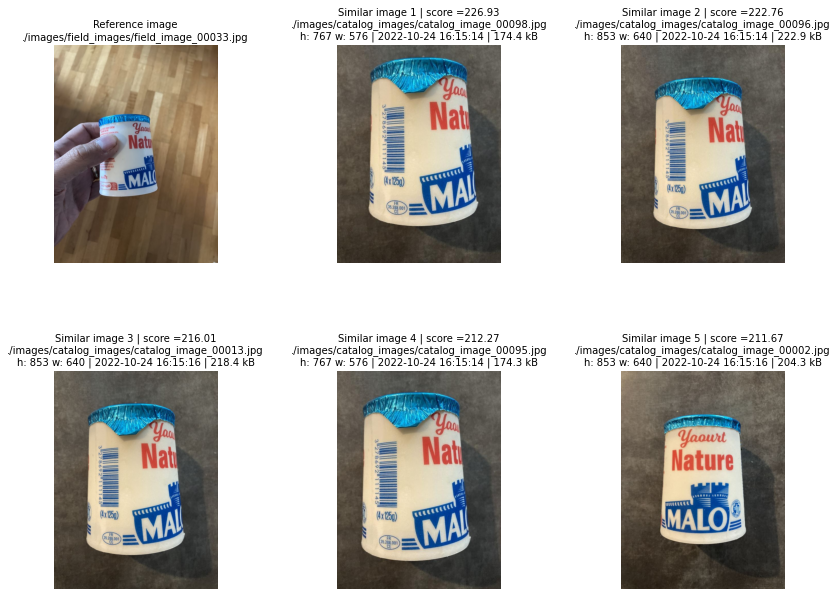

In [22]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

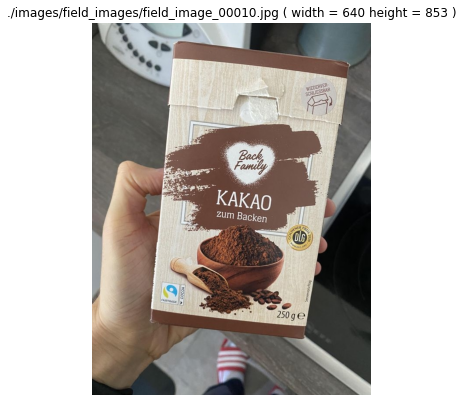

In [23]:
reference_image = FIELD_IMAGES + "field_image_00010.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [24]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=5)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 5 similar images of reference image: ./images/field_images/field_image_00010.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00230.jpg Similarity score = 285.60504 
 2 Similar image: ./images/catalog_images/catalog_image_00232.jpg Similarity score = 272.8906 
 3 Similar image: ./images/catalog_images/catalog_image_00451.jpg Similarity score = 270.31638 
 4 Similar image: ./images/catalog_images/catalog_image_00231.jpg Similarity score = 267.0915 
 5 Similar image: ./images/catalog_images/catalog_image_00216.jpg Similarity score = 180.0982 

Done in 1.23198 secs


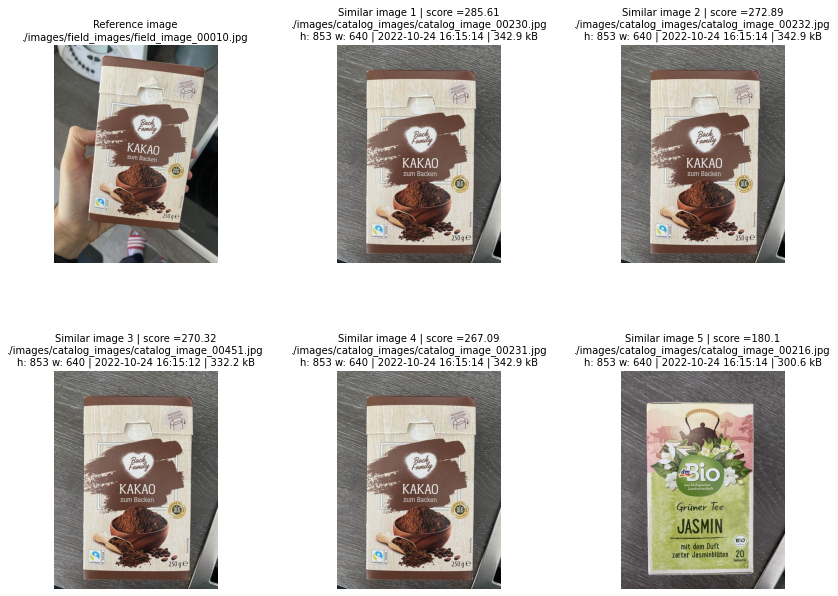

In [25]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

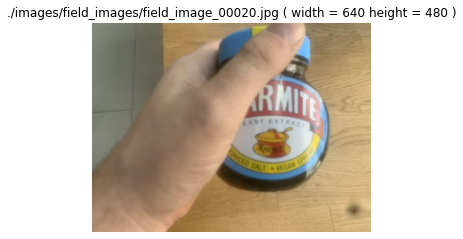

In [26]:
reference_image = FIELD_IMAGES + "field_image_00020.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [27]:
start = time.time()
similar_images_list, scores_images_list = acs.similar_images(
    reference_image, centers=clusterCenters, model=model, view=False, topn=4)
print("\nDone in", round((time.time() - start), 5), "secs")

Finding 4 similar images of reference image: ./images/field_images/field_image_00020.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00028.jpg Similarity score = 211.46028 
 2 Similar image: ./images/catalog_images/catalog_image_00318.jpg Similarity score = 195.27715 
 3 Similar image: ./images/catalog_images/catalog_image_00029.jpg Similarity score = 189.01361 
 4 Similar image: ./images/catalog_images/catalog_image_00317.jpg Similarity score = 175.36635 

Done in 1.22001 secs


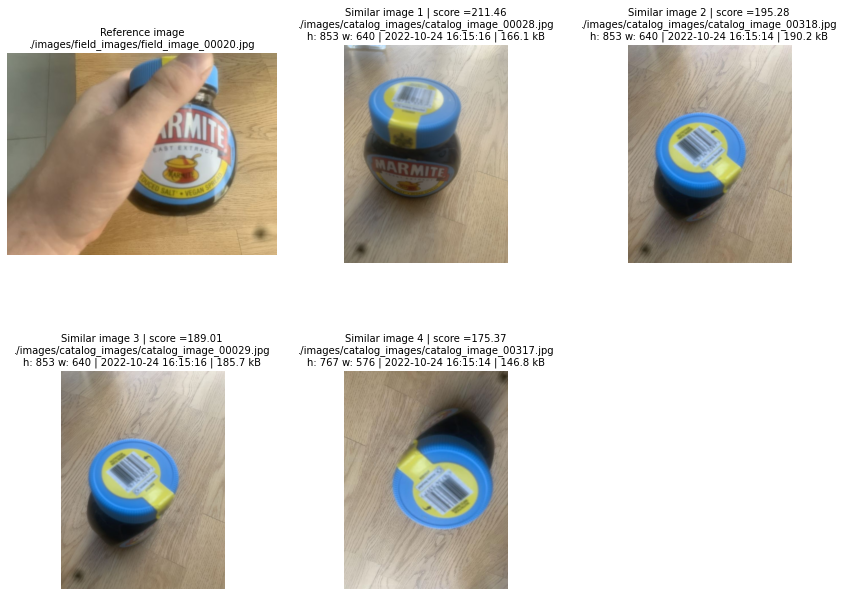

In [28]:
my.similar_images_display(reference_image,
                          similar_images_list,
                          scores_images_list,
                          w=15,
                          h=10,
                          nb_cols=3,
                          hspace=0.5,
                          wspace=0.05,
                          axis=False,
                          textsize=10)

## 5. Visual Search using Open AI Clip text

Finding 1 images with Open AI text query: BUTTER 

{'Content': './images/catalog_images/catalog_image_00345.jpg', '@search.score': 183.53438, '@search.highlights': None}

1 Image file: ./images/catalog_images/catalog_image_00345.jpg
Similarity score = 183.53438


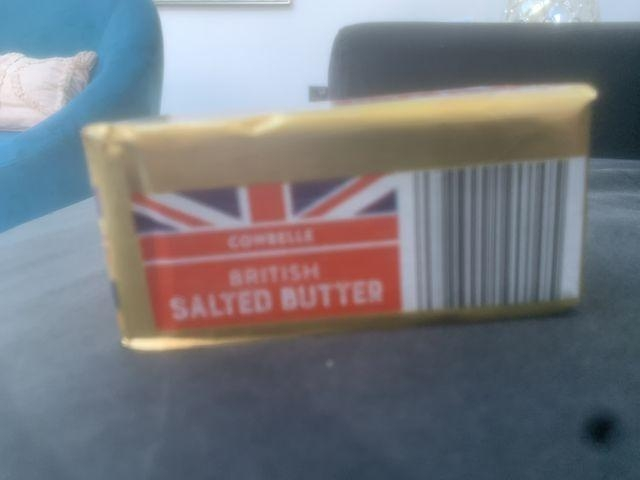

In [29]:
openai_text = "butter"

acs.sentence_transformers_query_search(openai_text,
                                       centers=clusterCenters,
                                       model=model,
                                       topn=1)

Finding 1 images with Open AI text query: JAM 

{'Content': './images/catalog_images/catalog_image_00134.jpg', '@search.score': 187.78787, '@search.highlights': None}

1 Image file: ./images/catalog_images/catalog_image_00134.jpg
Similarity score = 187.78787


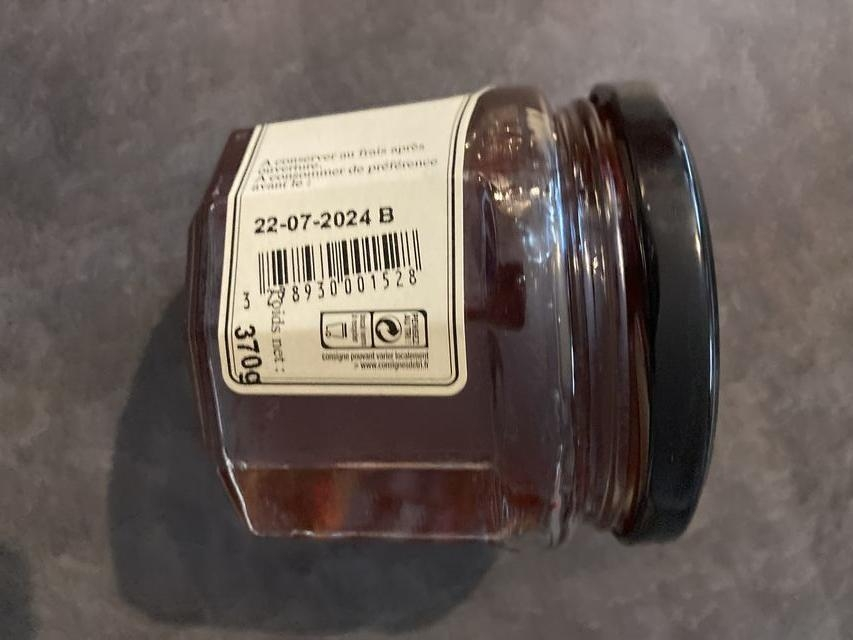

In [30]:
openai_text = "jam"

acs.sentence_transformers_query_search(openai_text,
                                       centers=clusterCenters,
                                       model=model,
                                       topn=1)

 ## 6. Searching images using extracted Text from Azure Read API

We can search on results from Azure Computer Vision & Azure Read API: OCR text, Barcode text, image tags, image main colors and image caption

In [31]:
text = "lait"

In [32]:
%%time
list_of_files = acs.open_text_query(text, False, 10)


Search using query = lait - note: displaying only the first 10 results 

 1 Image file: ./images/catalog_images/catalog_image_00082.jpg 

OCR:  MONOPRIX LAIT Lait 9 conditionné France DEMI ÉCRÉMÉ Oo CE LAIT RÉMUNÈRE AU JUSTE PRIX IL STÉRILISÉ U.H.T. 
BarCode:   
Colors:  Grey 
Tags:  text label packaging and labeling general supply material property blue floor 
Caption:  text  

 2 Image file: ./images/catalog_images/catalog_image_00083.jpg 

OCR:  A CONSOMMER DE PREFERENCE ANT LE ( N- DE LOT # (V)29 11. MONOPRIX LAIT Lait > collecté et conditionne France DEMI ÉCRÉMÉ CE LAIT RÉMUNÉRÉ AU JUSTE PRIK 14 STERILISE U.H.T. 
BarCode:   
Colors:  Grey 
Tags:  text packaging and labeling label box blue 
Caption:  a blue box with a label on it  

 3 Image file: ./images/catalog_images/catalog_image_00057.jpg 

OCR:  yoplait Crème ENTIÈRE Lait 100% 3 329770 062740 Français 38 cl ℮ 
BarCode:  3329770062740 
Colors:  Grey White 
Tags:  text bottle plastic bottle food indoor 
Caption:  a bottle of 

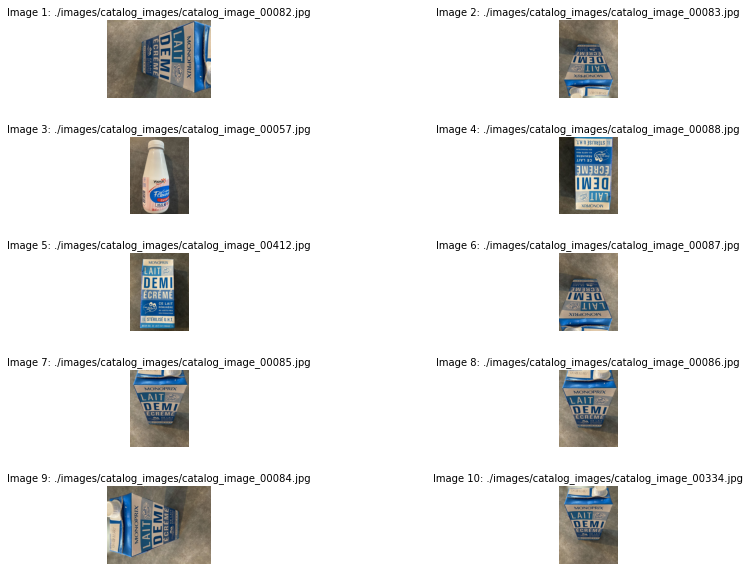

In [33]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

In [34]:
text = "sardine"

In [35]:
list_of_files = acs.open_text_query(text, False, 5)


Search using query = sardine - note: displaying only the first 5 results 

 1 Image file: ./images/catalog_images/catalog_image_00207.jpg 

OCR:  ALMARE Sardinen in Sonnen- SEAFOOD blumenöl, ohne Haut und ohne Gräten, mit Zitrone Zutaten: 75 %1 Sardinen, Sonnenblumenöl, Zitrone, Kochsalz. 1Gewichtsverlust durch Erhitzen. Nach dem Öffnen in einem nicht metallischen Behälter im Kühlschrank lagern und alsbald verzehren. Durchschnittliche Nährwerte Je 100 g Gesamtprodukt Handelsbezeichnung: Sardine Lat. Bezeichnung: Sardina pilchardus Brennwert 1352 KJ / 326 kcal Produktionsmethode: Wildfang (Meer) Fett Fangmethode: Umschließungsnetze 27 g - davon gesättigte und Hebenetze Fettsäuren 4,9 g Fanggerät: Ringwaden Fanggebiet: Mittlerer Ostatlantik (FAO 34) Kohlenhydrate <0,5 g Subfanggebiet: Nördliche Küstengewässer -davon Zucker <0,5 g Fangzeitraum: ganzjährig CROWN Eiweiß 20 g CHY CROWN Salz 0,73 g o trennt man richtig- Durchschnittliche Nährwerte unterliegen Gelbe jahreszeitlich bedingten S

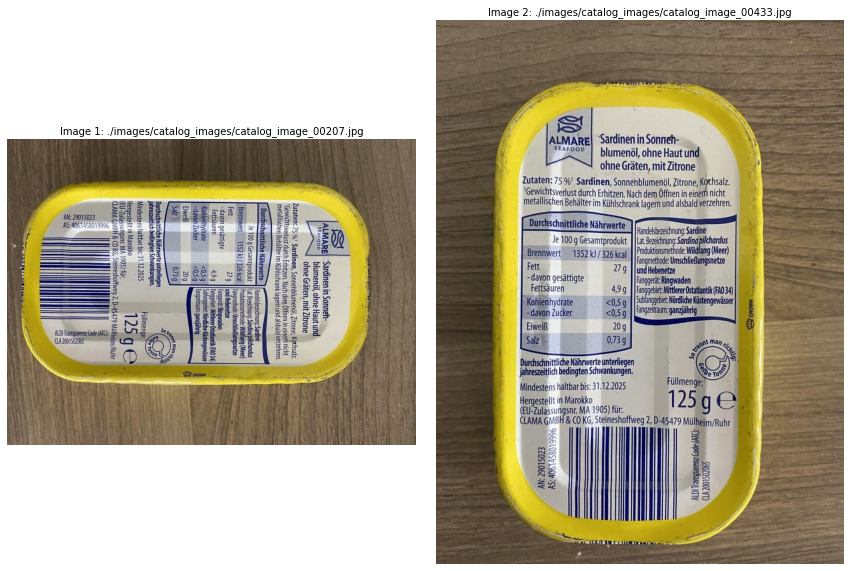

In [36]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

In [37]:
text = "4061458019996"

In [38]:
list_of_files = acs.open_text_query(text, False, 5)


Search using query = 4061458019996 - note: displaying only the first 5 results 

 1 Image file: ./images/catalog_images/catalog_image_00207.jpg 

OCR:  ALMARE Sardinen in Sonnen- SEAFOOD blumenöl, ohne Haut und ohne Gräten, mit Zitrone Zutaten: 75 %1 Sardinen, Sonnenblumenöl, Zitrone, Kochsalz. 1Gewichtsverlust durch Erhitzen. Nach dem Öffnen in einem nicht metallischen Behälter im Kühlschrank lagern und alsbald verzehren. Durchschnittliche Nährwerte Je 100 g Gesamtprodukt Handelsbezeichnung: Sardine Lat. Bezeichnung: Sardina pilchardus Brennwert 1352 KJ / 326 kcal Produktionsmethode: Wildfang (Meer) Fett Fangmethode: Umschließungsnetze 27 g - davon gesättigte und Hebenetze Fettsäuren 4,9 g Fanggerät: Ringwaden Fanggebiet: Mittlerer Ostatlantik (FAO 34) Kohlenhydrate <0,5 g Subfanggebiet: Nördliche Küstengewässer -davon Zucker <0,5 g Fangzeitraum: ganzjährig CROWN Eiweiß 20 g CHY CROWN Salz 0,73 g o trennt man richtig- Durchschnittliche Nährwerte unterliegen Gelbe jahreszeitlich bedin

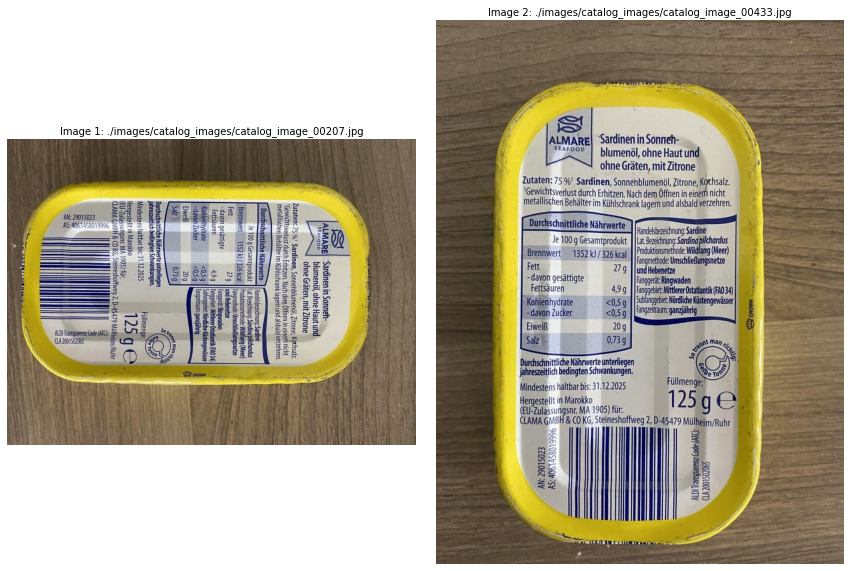

In [39]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

In [40]:
text = "red can"

In [41]:
list_of_files = acs.open_text_query(text, False, 10)


Search using query = red can - note: displaying only the first 10 results 

 1 Image file: ./images/catalog_images/catalog_image_00056.jpg 

OCR:  PROTE JE GA Tetra Pak® BUENO TOMATE FRITO Una vez abierto conservar en frigorífico y consumir antes de 5 días. Consumir preferentemente antes del fin de/lote: ver parte superior. PESO NETO: 350g ℮ 
BarCode:   
Colors:  Red 
Tags:  text label logo material property brand red 
Caption:  a red can of soda  

 2 Image file: ./images/catalog_images/catalog_image_00385.jpg 

OCR:  ERFORMACIÓN NUTRICIONAL ALTES MEDIOS A 100 &. DE PRODUCTO (PNE) MALSI EVERGETICO 651 2 kJ / 158,4 kcal DELAS CUALES 16 g 2.2 g US DE CARBONO 0.05 g FABRICADO POR: <0,05 g LA ESPAÑOLA' LA ESPAÑOLA 250 ALIMENTARIA ALCOYANA S.A. ARZOBISPO DOMENEDY 7 MANZANILLA FINA 03804 ALCOY - ALICANTE - ESINO WWW.LAESPANOLA.ES CENTAOER LIEL SABOR ANTE ACIDO CARICO. Mal Uso ta LOS 7 DIAS 150, ℮ NIEMENTE 350, 370. ---- 
BarCode:   
Colors:  Grey Red 
Tags:  text cylinder soft drink tin ca

BarCode:   
Colors:  Grey Red 
Tags:  text packaging and labeling soft drink label box tin can indoor 
Caption:  a box of cigarettes  

 46 Image file: ./images/catalog_images/catalog_image_00250.jpg 

OCR:   
BarCode:   
Colors:  Grey 
Tags:  soft drink tin can aluminum can container beverage can can 
Caption:  a close-up of a can  

 47 Image file: ./images/catalog_images/catalog_image_00271.jpg 

OCR:  SAXA SEA SALT cook 5 019989 103096 
BarCode:   
Colors:  Grey 
Tags:  indoor tin can text plastic tin aluminum can household supply soft drink cylinder container can 
Caption:  a blue and white can of soda  

 48 Image file: ./images/catalog_images/catalog_image_00006.jpg 

OCR:  SAXA SEA SALT FINE COOKY con 
BarCode:   
Colors:  Grey White 
Tags:  text indoor household supply tin can wall plastic floor 
Caption:  a blue and white can of soda  

 49 Image file: ./images/catalog_images/catalog_image_00189.jpg 

OCR:  Weiße Riesent ZUTATEN: Weiße Riesenbohnen, Wasser, Salz. Trocken lage

 64 Image file: ./images/catalog_images/catalog_image_00094.jpg 

OCR:  yaourt Nature MALO 
BarCode:   
Colors:  Grey White 
Tags:  text tin 
Caption:  a can of food  

 65 Image file: ./images/catalog_images/catalog_image_00024.jpg 

OCR:  YADIRT AU LAIT PARTIELLEMENT BREE PASTEURISE NATURE Ingrédients: Lait partielement écréné potente on Origine de lait:France ure Les informations en gras sont desbains VALEURS NUTRITIONNELLES POOL WO Energie: 224 KJ/50kcal Malltres grasses: 1.0g, dont acides grasstato il Glucides 6.7g, dont sucres L'À Putlines: Lag- Set Llig A conserver entre ('℃ et +1 ℃ quina. A consommer jusqu'au : voir sur l'perak Fabriqué par/ Service consonnoless Laitere de Saint Wal 25-400 SANT WUJ 200 salariés - www.malu.i RETACNE Poids net 125g 
BarCode:   
Colors:  Grey White 
Tags:  text indoor 
Caption:  a white can of food  

 66 Image file: ./images/catalog_images/catalog_image_00262.jpg 

OCR:   
BarCode:   
Colors:  Grey White 
Tags:  indoor household supply wall cylin

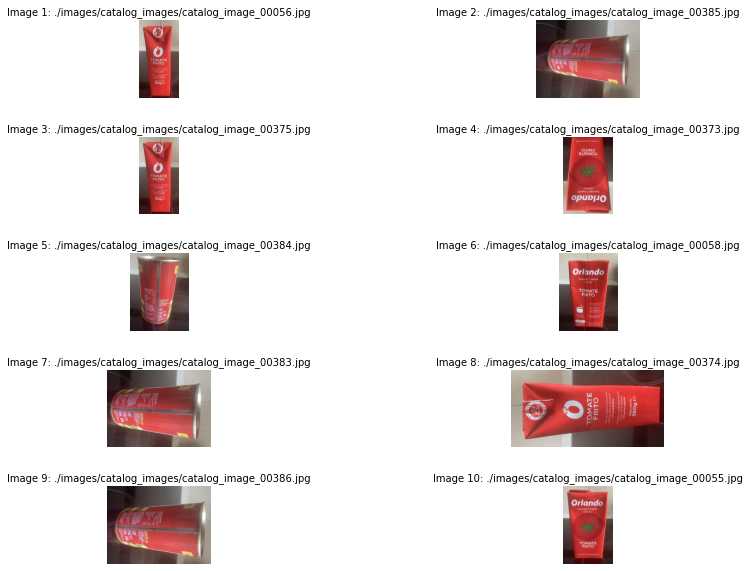

In [42]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

In [43]:
text = "www.orlando.es"

In [44]:
list_of_files = acs.open_text_query(text, False, 10)


Search using query = www.orlando.es - note: displaying only the first 10 results 

 1 Image file: ./images/catalog_images/catalog_image_00376.jpg 

OCR:  Orlando CALIDAD Y SABOR - DESDE 1922 - TOMATE FRITO El sofrito es la base de un buen tomate frito. Por eso en Orlando llevamos mas de 50 años preparar nuestro sofrito como el que tú haces en casa. Descubre cómo lo hacemos en: Así es como conseguimos www.orlando.es el auténtico sabor a tomate frito Orlando. SERVICIO AL CONSUMIDOR HJ Heinz Foods Spain SL. 902 94 51 84 Carretera Rincón de www.orlando.es Soto-Corella km 2,8 DFacebook 26540 Alfaro (La Rioja) 
BarCode:   
Colors:  Red 
Tags:  text material property label red 
Caption:  calendar  

 2 Image file: ./images/catalog_images/catalog_image_00058.jpg 

OCR:  Orlando CALIDAD Y SABOR - DESDE 1922 - TOMATE FRITO El sofrito es la base de un buen tomate frito. Por eso en Orlando llevamos más de 50 años preparando nuestro sofrito como el que tú haces en casa. Descubre cómo lo hacemos en

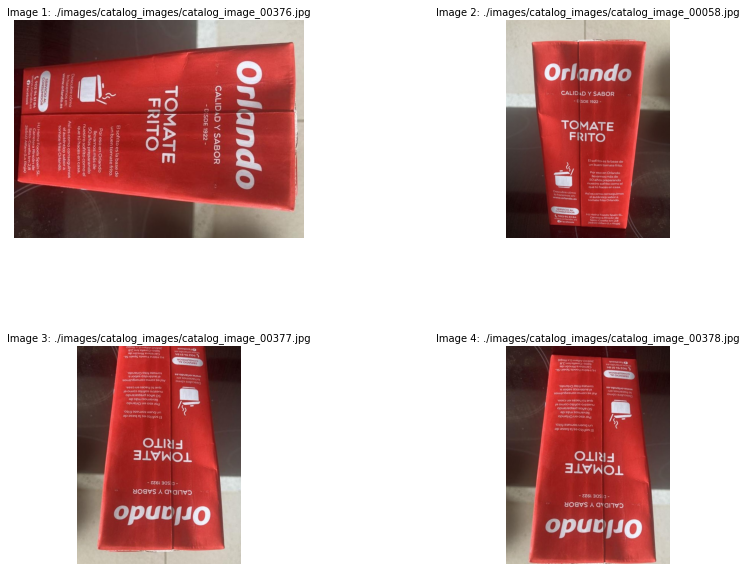

In [45]:
my.display_multiple_images(list_of_files, nb_cols=2, axis=False)

## 7. Global visual search using OpenAI Clip + Azure Read API + Azure Computer Vision + Barcode extraction)

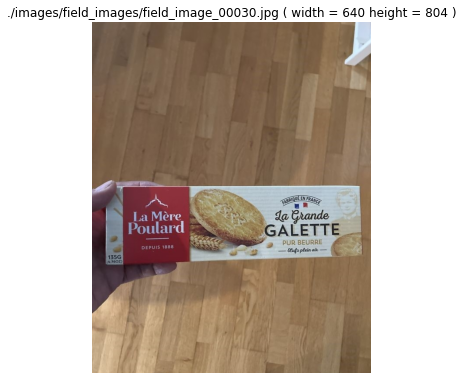

In [46]:
reference_image = FIELD_IMAGES + "field_image_00030.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [47]:
global_list, vectext_list, ocr_list, barcode_list = acs.global_search(
    reference_image, clusterCenters, model, topn=3)

[Step 1. Running images similarity visual search...]

Finding 3 similar images of reference image: ./images/field_images/field_image_00030.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00001.jpg Similarity score = 341.9913 
 2 Similar image: ./images/catalog_images/catalog_image_00076.jpg Similarity score = 285.5761 
 3 Similar image: ./images/catalog_images/catalog_image_00078.jpg Similarity score = 229.32793 

[Step 2. Extracting any text from the image...]

[Result] Text has been found:
OCR results from the image: FABRIQUÉ EN FRANCE La Mère Poulard La Grande GALETTE DEPUIS 1888 PUR BEURRE 135G - Œufs plein air - 4.76OZ


Search using query = FABRIQUÉ EN FRANCE La Mère Poulard La Grande GALETTE DEPUIS 1888 PUR BEURRE 135G - Œufs plein air - 4.76OZ - note: displaying only the first 3 results 

 1 Image file: ./images/catalog_images/catalog_image_00001.jpg 

OCR:  FABRIQUÉ EN FRANCE La Mère Poulard La Grande GALETTE DEPUIS 1888 PUR BEURRE 135G Œufs plein air - 4.7602) 


 14 Image file: ./images/catalog_images/catalog_image_00409.jpg 

OCR:  En 1692, le roi Louis XIV accorde au Sieur Damame le privilège exclusif de la vente du the en France. Ainsi débute l'aventure qui conduit la société Dammann Frères à établir des comptoirs aux quatre coins du monde à la recherche des meilleurs thes. In 1692, the King Louis XIV granted the exclusive privilege sale of tea to Mr. Damame in France. So the adventure began to lead Dammann Frères Company to establish counters all over the world in search of best teas. 3 259920 063962 DAMMANN INPLACE DESVAISGES PARIS 
BarCode:   
Colors:  Black Grey Orange 
Tags:  text book ground 
Caption:  text, letter  

 15 Image file: ./images/catalog_images/catalog_image_00046.jpg 

OCR:  ENTIÈRE eurette Creme en France Fabriqué 30% Mat. Gr. CETTE BOUTEILLE EST EXCLUSIVEMENT RESERVEE A UN USAGE ALIMENTAIRE YOPLAIT FRANCE - TSA 40100 92649 Boulogne-Billancourt Codex 7072003054 Pour 100ml Energie M 1529770 2740 1243 KJ 09.203.001 
BarCo

 51 Image file: ./images/catalog_images/catalog_image_00152.jpg 

OCR:  caramel El Od), ocid fonts focide .corres potasyumit coulcorants { acesulfame y. ett) arômes dont caféine conser ontintoussont (Dimethylpolysiloxane) de phenylalanine inneres moyennes pour une boisson Shouchon doseur jusqu'à la 250ml |['% pour 250 g* 3kj0,8 kcal 0g 0g 10% 0,05 g kerekrence chin arulle type (8400 kj/2000 kcal) por 150 ml. Confier environ 35 portions. apeppure selon les instructions alert le bouchon doseur juscinta la ligne du milieu. miembrod por SodaStream Infrasfries Ltd ., Ineer dos un endroit frais et sec, qu réfrigérateur. mettre Agiter ovan Jiemploi. PEPSI, PEPSI-COLA et le Logo Globe Pepsi sont des marques déposées par PepsiCo, Inc. mit dal préférence Falta le bouchon 4924602331-11/2020 8 719128 117249 
BarCode:   
Colors:  Black Grey 
Tags:  cylinder text bottle 
Caption:  a bottle of alcohol  

 52 Image file: ./images/catalog_images/catalog_image_00088.jpg 

OCR:  MONOPRIX LAIT Lait De Fra

 101 Image file: ./images/catalog_images/catalog_image_00056.jpg 

OCR:  PROTE JE GA Tetra Pak® BUENO TOMATE FRITO Una vez abierto conservar en frigorífico y consumir antes de 5 días. Consumir preferentemente antes del fin de/lote: ver parte superior. PESO NETO: 350g ℮ 
BarCode:   
Colors:  Red 
Tags:  text label logo material property brand red 
Caption:  a red can of soda  

 102 Image file: ./images/catalog_images/catalog_image_00130.jpg 

OCR:  PRIMEAL COUSCOUS MULTICÉRÉALES AU BOUILLON VÉGÉTAL Meergranen couscous met plantaardige bouillon FACILE 5,0 min FABRIQUE EN ORIGINE ISÈRE RF EUROPE CYCLABLE 
BarCode:   
Colors:  Grey Brown 
Tags:  text snack food ground 
Caption:  a bag of food  

 103 Image file: ./images/catalog_images/catalog_image_00193.jpg 

OCR:  400 g BIO BERGLINSEN Die Berglinse ist eine feine Linsenart mit kernigen duss 300 g Mit ihrem aromatisten Geschmack eignet sie sichideal für Salate, Beilagen oder Eintopfe Vor Wärme geschützt, trocken und dunkel lagern. CZ-BI

[Result] No barcode/QRCode has been found

Done in 6.80445 sec


In [48]:
df = pd.DataFrame()
df['image'] = global_list
df

image
0  ./images/catalog_images/catalog_image_00001.jpg
1  ./images/catalog_images/catalog_image_00076.jpg
2  ./images/catalog_images/catalog_image_00078.jpg
3  ./images/catalog_images/catalog_image_00223.jpg

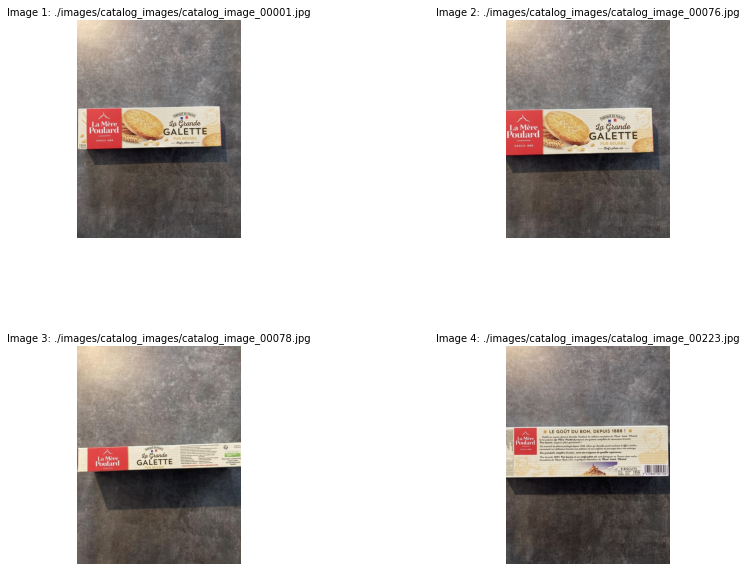

In [49]:
my.display_multiple_images(global_list, nb_cols=2, hspace=0.5, wspace=0.05, axis=False)

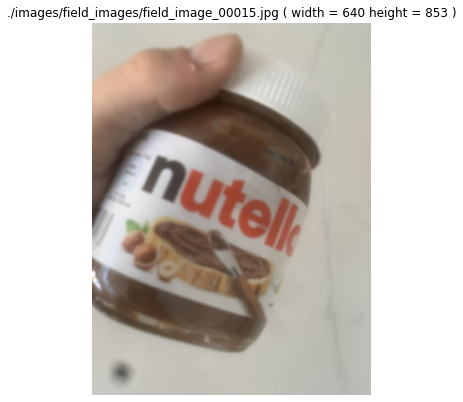

In [50]:
reference_image = FIELD_IMAGES + "field_image_00015.jpg"

my.image_view(reference_image, h=8, w=5, axis=False)

In [51]:
global_list, vectext_list, ocr_list, barcode_list = acs.global_search(
    reference_image, clusterCenters, model, topn=3)

[Step 1. Running images similarity visual search...]

Finding 3 similar images of reference image: ./images/field_images/field_image_00015.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00463.jpg Similarity score = 282.87506 
 2 Similar image: ./images/catalog_images/catalog_image_00260.jpg Similarity score = 276.9291 
 3 Similar image: ./images/catalog_images/catalog_image_00259.jpg Similarity score = 274.98682 

[Step 2. Extracting any text from the image...]

[Result] Text has been found:
OCR results from the image: nutell


Search using query = nutell - note: displaying only the first 3 results 


[Step 3. Extracting any text any barcode/QRCode of the image...]

[Result] No barcode/QRCode has been found

Done in 6.00032 sec


In [52]:
df = pd.DataFrame()
df['image'] = global_list
df

image
0  ./images/catalog_images/catalog_image_00463.jpg
1  ./images/catalog_images/catalog_image_00260.jpg
2  ./images/catalog_images/catalog_image_00259.jpg

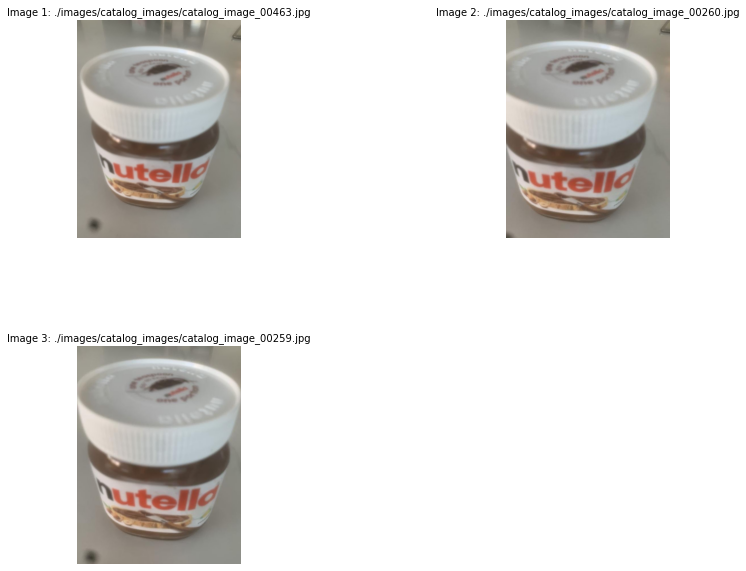

In [53]:
my.display_multiple_images(global_list, nb_cols=2, hspace=0.5, wspace=0.05, axis=False)

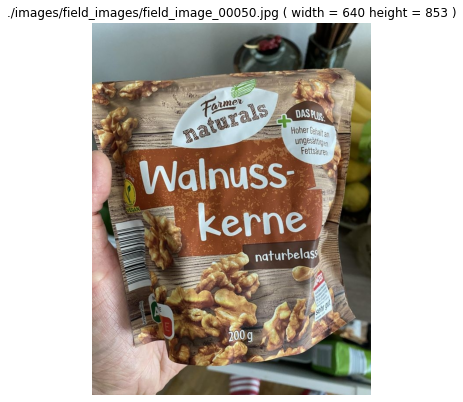

In [54]:
reference_image = FIELD_IMAGES + "field_image_00050.jpg"
my.image_view(reference_image, h=8, w=5, axis=False)

In [55]:
global_list, vectext_list, ocr_list, barcode_list = acs.global_search(
    reference_image, clusterCenters, model, topn=3)

[Step 1. Running images similarity visual search...]

Finding 3 similar images of reference image: ./images/field_images/field_image_00050.jpg 

 1 Similar image: ./images/catalog_images/catalog_image_00072.jpg Similarity score = 398.03738 
 2 Similar image: ./images/catalog_images/catalog_image_00071.jpg Similarity score = 233.4132 
 3 Similar image: ./images/catalog_images/catalog_image_00403.jpg Similarity score = 231.38455 

[Step 2. Extracting any text from the image...]

[Result] Text has been found:
OCR results from the image: Farmer DAS PLUS. naturals Hoher Gehalt an ungesättigten Walnuss- Fettsäuren VEGAN kerne naturbelass NE sehr gut E 200 g


Search using query = Farmer DAS PLUS. naturals Hoher Gehalt an ungesättigten Walnuss- Fettsäuren VEGAN kerne naturbelass NE sehr gut E 200 g - note: displaying only the first 3 results 

 1 Image file: ./images/catalog_images/catalog_image_00072.jpg 

OCR:  Farmer DAS PLUS .. naturals Hoher Gehalt an ungesättigten Fettsäuren Walnuss- ke

BarCode:  4066447123340 
Colors:  Grey White 
Tags:  text receipt screenshot printing menu 
Caption:  text, letter  

 24 Image file: ./images/catalog_images/catalog_image_00247.jpg 

OCR:  Farmer naturals Soft Durchschnittliche Nährwerte Je 200 g Datteln wennwert 1145\3/271 kcal -davon gesättigte <0,5g Fettsäuren <0,1 entsteint, getrocknet -davon Zocktt 52 Radlastutoffe 0.01 € *Enthält von Kabul a Lockint. Sort-Dattele, getrocknet, eatsteint. Exsfertig Zutaten: Getrocknete Datteln, Wasser. Die Farmer Naturals Soft- Datteln eignen och ideal als Zutat in Masll oder Joghurt. Aber auch zum Kochen oder als kleiner Snack zwischendurch sind die Datteln bestens geeignet. Nach dem Öffnen im Kühlschrank aufbewah ren und innerhalb von 10 Tagen verbrauchen. warnhinweis: Trotz mehrfacher Kontrolle uien sich auch bei sorgfältiger Verpackung Fandibrper (z.B. Stängel, Steine oder gebreste) nicht ganz vermeiden. Mindestens haltbar bis: AS: 4061462132300 erstellt für: Shel Janssen GmbH thestr. 180 Kilo

 51 Image file: ./images/catalog_images/catalog_image_00195.jpg 

OCR:  00 g BIO BERGLINSEN Die Berglinse ist eine feine Linsenart mit kemnigem Biss. 300 g Mit ihrem aromatischen Geschmack. eignet sie sich ideal für Salate, Beilagen oder Eintopfe. Vor Wärme geschützt, trocken und dunkel lagern. CZ-BIO-003 EU-/Nicht-EU 200 g Landwirtschaft Lo trennt mon richtig 205 elbe To PP 500 g 100 g LA Food s.r.o ., Kvitkovictd 1539 763 61 Napajedla, Tschechische Riqueklik info@lafoou.cz Mindestens haltbar bis! 13.12.2024 > 
BarCode:  4061458064637 
Colors:  Grey Green 
Tags:  text snack indoor green food wooden 
Caption:  a box of beans  

 52 Image file: ./images/catalog_images/catalog_image_00335.jpg 

OCR:  E GE R LE İCLIPSER SAINT LOUIS DEPUIS 1865 CASSONADE Sucre roux de canne NON NON RAFFINE 650 g 
BarCode:   
Colors:  Black Grey 
Tags:  text fruit food 
Caption:  company name  

 53 Image file: ./images/catalog_images/catalog_image_00417.jpg 

OCR:  Weiße Riesentr ZUTATEN: Weiße Riesenbohne

 101 Image file: ./images/catalog_images/catalog_image_00410.jpg 

OCR:  Planet SCORE LIBERTÉ FERMIERS Loué PARCOURS EXTERIEUR 2X PLUS GRAND COOPÉRATIVE POOLIS NOURRIES D'ÉLEVEURS Fermiers AUX CEREALES LOCALES w4/ 02/10 1958 Liberté hwting.amitt 
BarCode:   
Colors:  Black Grey 
Tags:  text fast food food indoor 
Caption:  website  

 102 Image file: ./images/catalog_images/catalog_image_00090.jpg 

OCR:  1987 H T069 246 2 01:00:54 R$ Numero de lot On vous en donne plus ! Aucune machine ne pouvant remplacer l'homme, nos jus sont dégustés quotidiennement par nos experts pour vérifier qu'ils restent toujours aussi délicieux On vous aime en pleine forme ! Des fruits, rien que des fruits dans notre pur jus ! Aucun conservateur, ni aucun sucre n'est ajouté conformément à la réglementation, comme pour tous les jus de fruits. Gorgé de saveurs, ce jus contient également les sucres naturellement présents dans les fruits. N'oubliez pas que l'eau est la seule boisson indispensable à votre santé. 

 151 Image file: ./images/catalog_images/catalog_image_00231.jpg 

OCR:  WIEDERVER- SCHLIESSBAR Back Family KAKAO zum Backen LDENER PREIS OLG WWW.ILGO Serviervorschlag FAIRTRADE 250 g ℮ COCOA 
BarCode:   
Colors:  Grey White Brown 
Tags:  text food dessert coffee chocolate 
Caption:  text  

 152 Image file: ./images/catalog_images/catalog_image_00224.jpg 

OCR:  leurs nutritionnelles pour 100g : Saveurs de Wwrote: 252kcal/ 1057kJ - Graisses : NORMANDIE André Guégrabe 15g (dont acides gras saturés : 0g) lucides : 62g (dont sucres : 62g) - Meines : 0,4g- Sel: < 0,01g Gelée delannoy Vanédients : fruits, sucre, pectine de Mipané aves 55 g de fruits pour Virey - 50600 Saint- Tél. 02 33 49 21 95 
BarCode:   
Colors:  Black Grey 
Tags:  text fruit preserve preserved food food storage containers lid food condiment canning mason jar lekvar bottle jam indoor 
Caption:  a jar of food  

 153 Image file: ./images/catalog_images/catalog_image_00074.jpg 

OCR:  KING'S Kidneybohuen CROWN Kidney-Bohn

[Result] Barcode/QRCode text has been found:
Barcode results from the image: 4061461689087


Search using query = 4061461689087 - note: displaying only the first 3 results 

 1 Image file: ./images/catalog_images/catalog_image_00400.jpg 

OCR:  Fammi naturals Walnuss Durchschnittliche Nährwerte kerne Je 100 g Brennwert 1954 63 / 716 kcal -davon gesättigte Fettsäuren - davon einfach ungesättigtesagen naturbelassen davon mehrfach ungesingefensauren 52.9 Kohlenhydrate DAS PLUS: -davon Zucker 3,7g 2.9 Eiweiß · Der Ersatz gesättigter Fettsäuren durch einfach Salz god/oder mehrfach ungesättigte Fettsäuren in der Emährung trägt zur Aufrechterhaltung eines normalen Cholesterinspiegels im Blut bei .* T. Walnüsse tragen dazu bei, die Elastizität der Blutgefäße zu verbessern .* Kalifornische Walnusskerne Betaten Walnusskerne. Kasa Spuren von anderen Schalenfrüchten und Erdolassen enthalten. Be positive wirkung stelt sich bei einem täglichen Verzehr 'S Waukenen ein, Eine abwechslungsreiche, ausgew

In [56]:
df = pd.DataFrame()
df['image'] = global_list
df

image
0  ./images/catalog_images/catalog_image_00072.jpg
1  ./images/catalog_images/catalog_image_00071.jpg
2  ./images/catalog_images/catalog_image_00403.jpg
3  ./images/catalog_images/catalog_image_00458.jpg
4  ./images/catalog_images/catalog_image_00242.jpg
5  ./images/catalog_images/catalog_image_00400.jpg
6  ./images/catalog_images/catalog_image_00402.jpg

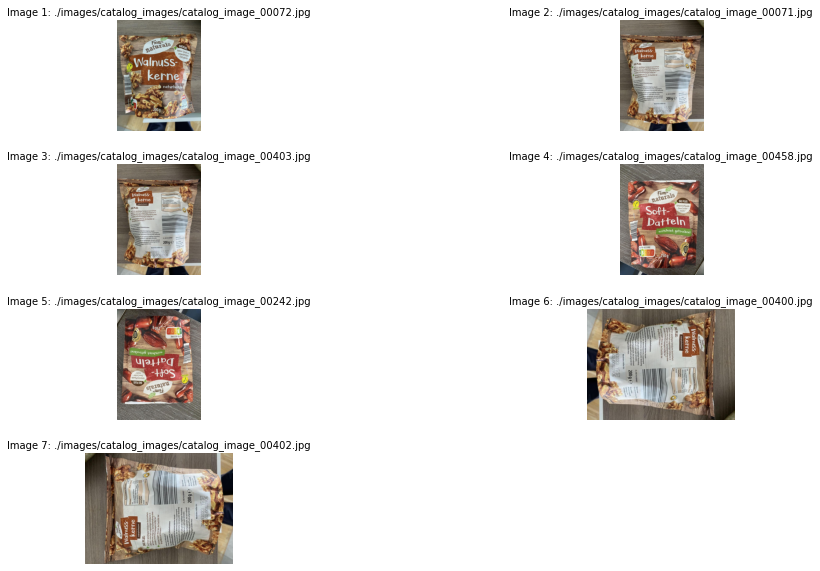

In [57]:
my.display_multiple_images(global_list, nb_cols=2, hspace=0.3, wspace=0.5, axis=False)

> End of notebook